# How To Ensemble OOF
In this notebook, we learn how to use `forward selection` to ensemble OOF. First build lots of models using the same KFolds (i.e. use same `seed`). Next save all the oof files as `oof_XX.csv` and submission files as `sub_XX.csv` where the oof and submission share the same `XX` number. Then save them in a Kaggle dataset and run the code below.

The ensemble begins with the model of highest oof AUC. Next each other model is added one by one to see which additional model increases ensemble AUC the most. The best additional model is kept and the process is repeated until the ensemble AUC doesn't increase.

# Read OOF Files
When i get more time, I will compete this table to describe all 39 models in this notebook. For now here are the ones that get selected:

| k | CV | LB | read size | crop size | effNet | ext data | upsample | misc | name |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 0.910 | 0.950 | 384 | 384 | B6 | 2018 | no |  | oof_100 |
| 3 | 0.916 | 0.946 | 384 | 384 | B345 | no | no |  | oof_108 |
| 8 | 0.935 | 0.949 | 768 | 512 | B7 | 2018 | 1,1,1,1 |  | oof_113 |
| 10 | 0.920 | 0.941 | 512 | 384 | B5 | 2019 2018 | 10,0,0,0 |  | oof_117 |
| 12 | 0.935 | 0.937 | 768 | 512 | B6 | 2019 2018 | 3,3,0,0 |  | oof_120 |
| 21 | 0.933 | 0.950 | 1024 | 512 | B6 | 2018 | 2,2,2,2 |  | oof_30 |
| 26 | 0.927 | 0.942 | 768 | 384 | B4 | 2018 | no |  | oof_385 |
| 37 | 0.936 | 0.956 | 512 | 384 | B5 | 2018 | 1,1,1,1 |  | oof_67 |


In [1]:
import pandas as pd, numpy as np, os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
PATH = '../input/melanoma-oof-and-sub/'
FILES = os.listdir(PATH)

OOF = np.sort( [f for f in FILES if 'oof' in f] )
OOF_CSV = [pd.read_csv(PATH+k) for k in OOF]

print('We have %i oof files...'%len(OOF))
print(); print(OOF)

We have 39 oof files...

['oof_0.csv' 'oof_100.csv' 'oof_105.csv' 'oof_108.csv' 'oof_109.csv'
 'oof_11.csv' 'oof_110.csv' 'oof_111.csv' 'oof_113.csv' 'oof_116.csv'
 'oof_117.csv' 'oof_12.csv' 'oof_120.csv' 'oof_121.csv' 'oof_13.csv'
 'oof_15.csv' 'oof_16.csv' 'oof_2.csv' 'oof_20.csv' 'oof_24.csv'
 'oof_28.csv' 'oof_30.csv' 'oof_32.csv' 'oof_33.csv' 'oof_35.csv'
 'oof_384.csv' 'oof_385.csv' 'oof_4.csv' 'oof_44.csv' 'oof_54.csv'
 'oof_55.csv' 'oof_56.csv' 'oof_57.csv' 'oof_58.csv' 'oof_59.csv'
 'oof_6.csv' 'oof_65.csv' 'oof_67.csv' 'oof_77.csv']


In [3]:
x = np.zeros(( len(OOF_CSV[0]),len(OOF) ))
for k in range(len(OOF)):
    x[:,k] = OOF_CSV[k].pred.values
    
TRUE = OOF_CSV[0].target.values

In [4]:
all = []
for k in range(x.shape[1]):
    auc = roc_auc_score(OOF_CSV[0].target,x[:,k])
    all.append(auc)
    print('Model %i has OOF AUC = %.4f'%(k,auc))
    
m = [np.argmax(all)]; w = []

Model 0 has OOF AUC = 0.9038
Model 1 has OOF AUC = 0.9096
Model 2 has OOF AUC = 0.9116
Model 3 has OOF AUC = 0.9162
Model 4 has OOF AUC = 0.9231
Model 5 has OOF AUC = 0.9206
Model 6 has OOF AUC = 0.9234
Model 7 has OOF AUC = 0.9267
Model 8 has OOF AUC = 0.9353
Model 9 has OOF AUC = 0.9033
Model 10 has OOF AUC = 0.9199
Model 11 has OOF AUC = 0.9178
Model 12 has OOF AUC = 0.9347
Model 13 has OOF AUC = 0.9238
Model 14 has OOF AUC = 0.9182
Model 15 has OOF AUC = 0.9196
Model 16 has OOF AUC = 0.9160
Model 17 has OOF AUC = 0.9267
Model 18 has OOF AUC = 0.9260
Model 19 has OOF AUC = 0.9306
Model 20 has OOF AUC = 0.9310
Model 21 has OOF AUC = 0.9331
Model 22 has OOF AUC = 0.8979
Model 23 has OOF AUC = 0.9148
Model 24 has OOF AUC = 0.9216
Model 25 has OOF AUC = 0.9278
Model 26 has OOF AUC = 0.9267
Model 27 has OOF AUC = 0.9229
Model 28 has OOF AUC = 0.9277
Model 29 has OOF AUC = 0.9328
Model 30 has OOF AUC = 0.9243
Model 31 has OOF AUC = 0.9012
Model 32 has OOF AUC = 0.9129
Model 33 has OOF AUC

# Build OOF Ensemble. Maximize CV Score

In [5]:
old = np.max(all); 

RES = 200; 
PATIENCE = 10; 
TOL = 0.0003
DUPLICATES = False

print('Ensemble AUC = %.4f by beginning with model %i'%(old,m[0]))
print()

for kk in range(len(OOF)):
    
    # BUILD CURRENT ENSEMBLE
    md = x[:,m[0]]
    for i,k in enumerate(m[1:]):
        md = w[i]*x[:,k] + (1-w[i])*md
        
    # FIND MODEL TO ADD
    mx = 0; mx_k = 0; mx_w = 0
    print('Searching for best model to add... ')
    
    # TRY ADDING EACH MODEL
    for k in range(x.shape[1]):
        print(k,', ',end='')
        if not DUPLICATES and (k in m): continue
            
        # EVALUATE ADDING MODEL K WITH WEIGHTS W
        bst_j = 0; bst = 0; ct = 0
        for j in range(RES):
            tmp = j/RES*x[:,k] + (1-j/RES)*md
            auc = roc_auc_score(TRUE,tmp)
            if auc>bst:
                bst = auc
                bst_j = j/RES
            else: ct += 1
            if ct>PATIENCE: break
        if bst>mx:
            mx = bst
            mx_k = k
            mx_w = bst_j
            
    # STOP IF INCREASE IS LESS THAN TOL
    inc = mx-old
    if inc<=TOL: 
        print(); print('No increase. Stopping.')
        break
        
    # DISPLAY RESULTS
    print(); #print(kk,mx,mx_k,mx_w,'%.5f'%inc)
    print('Ensemble AUC = %.4f after adding model %i with weight %.3f. Increase of %.4f'%(mx,mx_k,mx_w,inc))
    print()
    
    old = mx; m.append(mx_k); w.append(mx_w)

Ensemble AUC = 0.9358 by beginning with model 37

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 
Ensemble AUC = 0.9426 after adding model 21 with weight 0.480. Increase of 0.0068

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 
Ensemble AUC = 0.9461 after adding model 3 with weight 0.565. Increase of 0.0035

Searching for best model to add... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 
Ensemble AUC = 0.9475 after adding model 12 with weight 0.145. Increase of 0.0014

Searching for best model to add... 


In [6]:
print('We are using models',m)
print('with weights',w)
print('and achieve ensemble AUC = %.4f'%old)

We are using models [37, 21, 3, 12, 1, 26, 8, 10]
with weights [0.48, 0.565, 0.145, 0.3, 0.065, 0.125, 0.055]
and achieve ensemble AUC = 0.9499


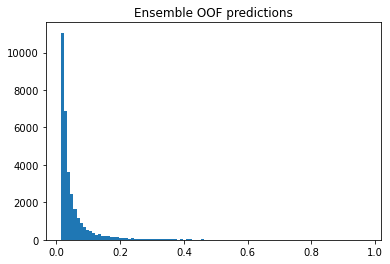

In [7]:
md = x[:,m[0]]
for i,k in enumerate(m[1:]):
    md = w[i]*x[:,k] + (1-w[i])*md
plt.hist(md,bins=100)
plt.title('Ensemble OOF predictions')
plt.show()

In [8]:
df = OOF_CSV[0].copy()
df.pred = md
df.to_csv('ensemble_oof.csv',index=False)

# Load SUB Files

In [9]:
SUB = np.sort( [f for f in FILES if 'sub' in f] )
SUB_CSV = [pd.read_csv(PATH+k) for k in SUB]

print('We have %i submission files...'%len(SUB))
print(); print(SUB)

We have 39 submission files...

['sub_0.csv' 'sub_100.csv' 'sub_105.csv' 'sub_108.csv' 'sub_109.csv'
 'sub_11.csv' 'sub_110.csv' 'sub_111.csv' 'sub_113.csv' 'sub_116.csv'
 'sub_117.csv' 'sub_12.csv' 'sub_120.csv' 'sub_121.csv' 'sub_13.csv'
 'sub_15.csv' 'sub_16.csv' 'sub_2.csv' 'sub_20.csv' 'sub_24.csv'
 'sub_28.csv' 'sub_30.csv' 'sub_32.csv' 'sub_33.csv' 'sub_35.csv'
 'sub_384.csv' 'sub_385.csv' 'sub_4.csv' 'sub_44.csv' 'sub_54.csv'
 'sub_55.csv' 'sub_56.csv' 'sub_57.csv' 'sub_58.csv' 'sub_59.csv'
 'sub_6.csv' 'sub_65.csv' 'sub_67.csv' 'sub_77.csv']


In [10]:
# VERFIY THAT SUBMISSION FILES MATCH OOF FILES
a = np.array( [ int( x.split('_')[1].split('.')[0]) for x in SUB ] )
b = np.array( [ int( x.split('_')[1].split('.')[0]) for x in OOF ] )
if len(a)!=len(b):
    print('ERROR submission files dont match oof files')
else:
    for k in range(len(a)):
        if a[k]!=b[k]: print('ERROR submission files dont match oof files')

In [11]:
y = np.zeros(( len(SUB_CSV[0]),len(SUB) ))
for k in range(len(SUB)):
    y[:,k] = SUB_CSV[k].target.values

# Build SUB Ensemble

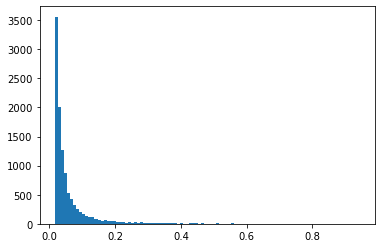

In [12]:
md2 = y[:,m[0]]
for i,k in enumerate(m[1:]):
    md2 = w[i]*y[:,k] + (1-w[i])*md2
plt.hist(md2,bins=100)
plt.show()

In [13]:
df = SUB_CSV[0].copy()
df.target = md2
df.to_csv('ensemble_sub.csv',index=False)